In [3]:
using Plots
using Statistics
using FFTW
using DSP

In [5]:
include("../helpers/importing.jl")
lfp = import_lfp("Exp 2/R7/2022-05-11_17-39-17/Record Node 113/")

Dict{String, Any} with 5 entries:
  "laser"      => Dict("off"=>[326750.0, 449113.0, 494635.0, 534317.0, 626549.0…
  "sync"       => Dict("off"=>[28499.0, 39004.0, 49509.0, 60014.0, 70519.0, 810…
  "oxygen"     => Dict("off"=>[], "on"=>[25998.0])
  "data"       => Float32[7.02 13.65 … 0.0 0.0; -2.925 -3.12 … 0.0 0.0; -0.78 -…
  "timestamps" => [25800.0, 25801.0, 25802.0, 25803.0, 25804.0, 25805.0, 25806.…

# Leaky Integrator

The goal of this notebook is to create a leaky integrator which smooths a signal. This can be used to relate signals with higher frequency components to signals with lower frequency components.

$$\tau \dot{v} = S-v$$

where S is the LFP signal.

General Solution:

$$v(t) = ke^{-t/\tau}+S$$

$$v(t) = k(e^{-t}-e^{\tau})+S$$

$$v(t) = ke^{-t} - ke^{\tau}+S$$

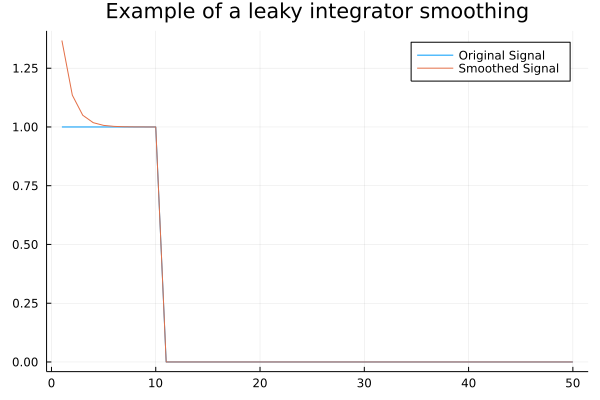

In [17]:
S(t) = cat(ones(10), zeros(40); dims=1)[t]
k = 1
A = 1
v(t) = k*exp(-A*t) + S(t)/A

region = (1:50)
plot(region, S.(region), label="Original Signal")
plot!(region, v.(region), label="Smoothed Signal")

title!("Example of a leaky integrator smoothing")

## Iterative Solution

The solution above works but as the data is at discrete time intervals, an iterative solution can also be defined. The method below was taken from this [resource](https://www.mbfys.ru.nl/~robvdw/DGCN22/PRACTICUM_2011/LABS_2011/ALTERNATIVE_LABS/Lesson_12.html#1).

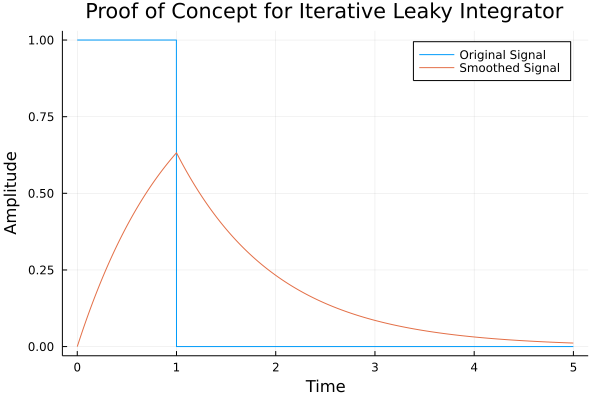

In [10]:
dt = .001
maxt = 5
t = 0:dt:(maxt-dt)
nt = length(t)

k=1

s  = cat(ones(div(length(t), 5)), zeros(4*div(length(t),5)); dims=1)

y = zeros(length(t));
for i in 1:(nt-1)
    dy = s[i]-y[i]/k;
    y[i+1] = y[i]+dy*dt;
end

plot(t, s, label="Original Signal")
plot!(t, y, label="Smoothed Signal")
title!("Proof of Concept for Iterative Leaky Integrator")
xlabel!("Time")
ylabel!("Amplitude")

In [12]:
# Compute the Fourier Transform
sampling_rate = 1000
freqs = fftfreq(length(lfp["data"][1,:]), sampling_rate)

# Butterworth's low pass filter equation
function butterworth_low(freq, pass_freq, n=5)
    return 1 / (1 + (abs(freq) / pass_freq) ^ 2n)
end

# Butterworth's high pass filter equation
function butterworth_high(freq, pass_freq, n=5)
    return 1 / (1 + (pass_freq / abs(freq)) ^ 2n)
end


# Apply the Band-Pass Butterworth filter
band = [1, 45]
lfp_envelopes = []
for i in 1:length(lfp["data"][:,1])
    F = fft(lfp["data"][i, :])
    for i in 1:length(F)
        F[i] = F[i] * butterworth_high(freqs[i], band[1]) * butterworth_low(freqs[i], band[2]) 
    end
    banded_lfp = real(ifft(F))
    push!(lfp_envelopes, abs.(hilbert(banded_lfp)))
end
lfp_envelopes

4-element Vector{Any}:
 Float32[4.9838405, 4.9234977, 4.8989406, 4.9306765, 5.0365987, 5.2286115, 5.5107465, 5.8788834, 6.322353, 6.8263903  …  4.6198053, 4.8124385, 4.971924, 5.0941176, 5.176647, 5.2188077, 5.222476, 5.1917224, 5.133963, 5.0599093]
 Float32[5.060112, 5.4845376, 5.900652, 6.302981, 6.686522, 7.046374, 7.3785267, 7.6792107, 7.945402, 8.174485  …  1.8203062, 1.9539348, 2.146853, 2.3955414, 2.6931434, 3.031449, 3.4022295, 3.797683, 4.2103834, 4.633389]
 Float32[2.1681204, 1.7904098, 1.4725891, 1.3256718, 1.4570332, 1.8407288, 2.3747172, 2.9864235, 3.6362503, 4.3008585  …  3.8539493, 3.9093902, 3.920931, 3.884009, 3.7949715, 3.6514263, 3.452391, 3.1987433, 2.8940248, 2.5456462]
 Float32[2.4219582, 2.7042103, 3.0043478, 3.3188848, 3.6451855, 3.980942, 4.324243, 4.672922, 5.024373, 5.3749714  …  1.417228, 1.3758608, 1.3487428, 1.346, 1.3774263, 1.4504822, 1.5681841, 1.7292023, 1.9289912, 2.161823]

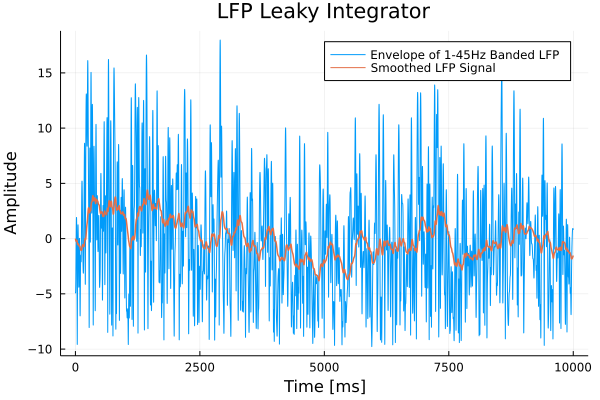

In [13]:
maxt = 10000
t = (1:maxt)
nt = length(t)

k = 0.2

s = lfp_envelopes[1][t] .- mean(lfp_envelopes[1][t])

y = zeros(length(t));
for i in 1:(nt-1)
    dy = (s[i]-y[i])/k;
    y[i+1] = y[i]+dy*dt;
end

plot(t,s, label="Envelope of 1-45Hz Banded LFP")
plot!(t,y, label="Smoothed LFP Signal", linewidth=1.5)
title!("LFP Leaky Integrator")
xlabel!("Time [ms]")
ylabel!("Amplitude")

Now that a useable algorithm has been created, it will be moved over to a helper function which can be found in [filtering.jl](../helpers/filtering.jl).

## Testing Helper Function

This section will run the code that has been moved into the helper function to ensure that it has the desired output.

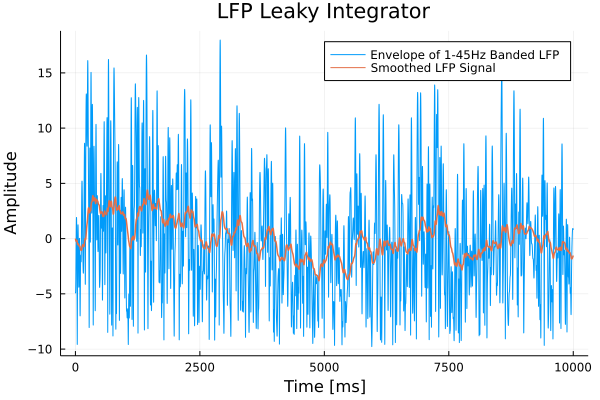

In [14]:
include("../helpers/filtering.jl")

y = leaky_integrator(lfp_envelopes[1][t] .- mean(lfp_envelopes[1][t]); k=0.2)

plot(t,s, label="Envelope of 1-45Hz Banded LFP")
plot!(t,y, label="Smoothed LFP Signal", linewidth=1.5)
title!("LFP Leaky Integrator")
xlabel!("Time [ms]")
ylabel!("Amplitude")

As the graph produced is identical to the previous, there is some assurance that the helper function works.